In [22]:
# 字詞前處理
# 在進行字詞向量化之前，我們需要針對文本資料進行前置處理，將文本資料分割成字詞(斷詞)**，再將分割後的字詞轉換成字詞ID清單**

#導入會使用的library
import re
import numpy as np
from typing import List

#定義前處理函式
def preprocess(corpus: List[str], only_word: bool = False):
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    '''
    word_dic = set()
    processed_sentence = []
    
    for sentence in corpus:
        #將所有字詞轉為小寫
        sentence = sentence.lower()

        #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
        if only_word:
            pattern = r'[^\W_]+'
            sentence = re.findall(pattern, sentence)
        else:
            punctuation_list = ['.', ',', '!', '?']
            for pun in punctuation_list:
                sentence = sentence.replace(pun, ' '+pun)
            sentence = sentence.split(' ')
        
        #添加字詞到字典中
        word_dic |= set(sentence)
        processed_sentence.append(sentence)
    
    
    #建立字詞ID清單
    word2idx = dict()
    idx2word = dict()
    for word in word_dic:
        if word not in word2idx:
            idx = len(word2idx)
            word2idx[word] = idx
            idx2word[idx] = word

    #將文本轉為ID型式
    id_mapping = lambda x: word2idx[x]
    
    corpus = np.array([list(map(id_mapping, sentence)) for sentence in processed_sentence])

    return corpus, word2idx, idx2word

#定義簡易文本資料(使用Ch17講義中的例子)
corpus = ['You say goodbye and I say hello.']

processed_corpus, word2idx, idx2word = preprocess(corpus)
print(f'Processed corpus: {processed_corpus} \n word2idx: {word2idx} \n idx2word: {idx2word}')

Processed corpus: [[1 5 4 6 3 5 2 0]] 
 word2idx: {'.': 0, 'you': 1, 'hello': 2, 'i': 3, 'goodbye': 4, 'say': 5, 'and': 6} 
 idx2word: {0: '.', 1: 'you', 2: 'hello', 3: 'i', 4: 'goodbye', 5: 'say', 6: 'and'}


In [2]:
# 共現矩陣
# 將轉化處理過的文本資料轉化為共現矩陣

#定義共現矩陣函式
def create_co_matrix(corpus: np.ndarray, vocab_size: int, window_size: int=1):
    '''
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype=np.int32)
    
    for sentence in corpus:
        sentence_size = len(sentence)
    
        for idx, word_id in enumerate(sentence):
            for i in range(1, window_size+1):
                left_idx = idx - i
                right_idx = idx + i

                if left_idx >= 0:
                    left_word_id = sentence[left_idx]
                    co_matrix[word_id, left_word_id] += 1

                if right_idx < sentence_size:
                    right_word_id = sentence[right_idx]
                    co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

co_matrix = create_co_matrix(processed_corpus, len(word2idx), 2)
co_matrix

array([[0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 2],
       [0, 0, 0, 1, 1, 2, 0]])

In [15]:
# 定義共現矩陣函式
# method two

def create_co_matrix(corpus: np.ndarray, vocab_size: int, window_size: int=1):
    '''
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype=np.int32)
    
    for sentence in corpus:
        sentence_size = len(sentence)
    
        for idx, word_id in enumerate(sentence):
            left_idx = idx - window_size if idx - window_size >= 0 else 0
            context_ids = sentence[left_idx:idx]
            
            for left_i, left_id in enumerate(context_ids):
                co_matrix[word_id, left_id] += 1
                co_matrix[left_id, word_id] += 1

    return co_matrix

co_matrix = create_co_matrix(processed_corpus, len(word2idx), 2)
co_matrix

array([[0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 2],
       [0, 0, 0, 1, 1, 2, 0]])

In [16]:
# 向量間相似度
# 比較轉換為向量的字詞的方法有很多種，其中當要表示字詞的相似度時，最常使用的方法為餘弦相似度 (Cosine Similarity)
# 定義餘弦相似度
def cos_similarity(x: np.ndarray, y: np.ndarray, eps: float=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx,ny)

# calculate the similarity between I and you
cos_similarity(co_matrix[word2idx['i']], co_matrix[word2idx['you']])

0.7071067726510136

In [4]:
#建立可供查詢相似度的函數
# 輸入字詞，查詢與此字詞top_n相似的結果
def top_k_similarity(query: str, word2idx: dict, idx2word: dict, word_matrix: np.ndarray, top_k: int=3):
    # handle the situation of query word not in corpus
    if query not in word2idx:
        raise ValueError(f"{query} is not found in input dictionary")
        
    print(f"[query] : {query}")
    query_id = word2idx[query]
    query_vec = word_matrix[query_id]
    
    # calculate cosine similarity
    similarity_scores = np.zeros(len(word2idx))
    for i in range(len(word2idx)):
        similarity_scores[i] = cos_similarity(query_vec, word_matrix[i])

    # remove query word
    similarity_scores = np.delete(similarity_scores, query_id)
    filter_word2idx = dict([(k, v) for k, v in word2idx.items() if k != query])
    filter_idx2word = dict([(k, v) for k, v in idx2word.items() if k != query_id])
    
    # sorting by similarity score
    top_k_idx = (-similarity_scores).argsort()[:top_k]
    top_k_word = [filter_idx2word[word_idx] for word_idx in filter_idx2word]
    
    return dict(zip(top_k_word, similarity_scores[top_k_idx]))

In [17]:
top_k_similarity('you', word2idx, idx2word, co_matrix, 3)

[query] : you


{'.': 0.8660253941251803,
 'hello': 0.7071067726510136,
 'i': 0.49999999292893216}

In [7]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]

    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

In [8]:
output_ppmi = ppmi(co_matrix, verbose=True)
output_ppmi

10/49 Done
20/49 Done
30/49 Done
40/49 Done
49/49 Done


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[0.       , 0.       , 2.1154773, 0.       , 0.       , 0.8930848,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 1.7004397, 0.8930848,
        0.       ],
       [2.1154773, 0.       , 0.       , 1.1154772, 0.       , 0.3081223,
        0.       ],
       [0.       , 0.       , 1.1154772, 0.       , 0.7004397, 0.       ,
        0.7004397],
       [0.       , 1.7004397, 0.       , 0.7004397, 0.       , 0.       ,
        0.7004397],
       [0.8930848, 0.8930848, 0.3081223, 0.       , 0.       , 0.       ,
        0.8930848],
       [0.       , 0.       , 0.       , 0.7004397, 0.7004397, 0.8930848,
        0.       ]], dtype=float32)

In [9]:
# 使用np的linalg.svd對PPMI矩陣進行奇異值分解

# SVD
U, S, V = np.linalg.svd(output_ppmi)

# 使用SVD將將原本的稀疏向量轉變為稠密向量
print(f'hello in co-occurrence matrix: {co_matrix[0]}')
print(f"hello in PPMI: {output_ppmi[0]}")
print(f"hello in SVD: {U[0]}")

hello in co-occurrence matrix: [0 0 1 0 0 1 0]
hello in PPMI: [0.        0.        2.1154773 0.        0.        0.8930848 0.       ]
hello in SVD: [-0.48203    -0.56445074 -0.26282662  0.430857    0.33953863 -0.2642201
 -0.09606315]


In [10]:
# 檢查分解是否正確
A = U @ np.diag(S) @ V
print(A)
print(output_ppmi)
# 可以發先做完SVD得結果跟原來的output_ppmi是相同的

[[-1.76178805e-08 -6.68377638e-08  2.11547732e+00  1.77927717e-08
  -5.17287262e-08  8.93084824e-01 -5.30116395e-08]
 [-7.11651316e-09  1.92635028e-08 -4.49460344e-08  1.34603795e-08
   1.70043969e+00  8.93084764e-01  1.45025325e-09]
 [ 2.11547732e+00 -4.88651040e-08 -3.03451451e-08  1.11547709e+00
   1.45353560e-08  3.08122247e-01 -5.35544444e-08]
 [ 1.78285688e-08  1.35580214e-08  1.11547709e+00  1.23703447e-08
   7.00439751e-01  1.72256680e-08  7.00439632e-01]
 [-3.84810370e-08  1.70043981e+00 -4.64926551e-08  7.00439751e-01
   6.17670821e-08  1.91322336e-09  7.00439692e-01]
 [ 8.93084824e-01  8.93084764e-01  3.08122218e-01 -2.37586200e-08
   4.47104114e-08  2.52935042e-08  8.93084824e-01]
 [-5.40167093e-08 -4.47034836e-08 -4.84287739e-08  7.00439632e-01
   7.00439632e-01  8.93084884e-01 -1.49011612e-08]]
[[0.        0.        2.1154773 0.        0.        0.8930848 0.       ]
 [0.        0.        0.        0.        1.7004397 0.8930848 0.       ]
 [2.1154773 0.        0.        1.

In [11]:
# 可以發現前六個奇異值就佔了絕大多數的奇異值
print(S)

# 可以取前六個維度當作降為的詞向量
U_reduce = U[:, 0:6]
U_reduce

[2.9371588  2.5547988  2.1101685  1.9556583  1.1257027  0.58972406
 0.30812874]


array([[-0.48203   , -0.56445074, -0.26282662,  0.430857  ,  0.33953863,
        -0.2642201 ],
       [-0.29432744, -0.29746115,  0.5294562 , -0.511355  , -0.22169203,
        -0.35262936],
       [-0.5126197 ,  0.5698161 ,  0.39725903,  0.4323913 ,  0.01054526,
         0.124419  ],
       [-0.33312967, -0.30777904, -0.16466641, -0.03673923, -0.5294517 ,
         0.6964652 ],
       [-0.31352073,  0.30776063, -0.48896635, -0.5457005 ,  0.38465765,
         0.12412582],
       [-0.3710324 ,  0.26495245, -0.31999645, -0.0807369 , -0.45295563,
        -0.4691856 ],
       [-0.26702777, -0.09261478,  0.3523957 , -0.24547683,  0.44945022,
         0.26410997]], dtype=float32)

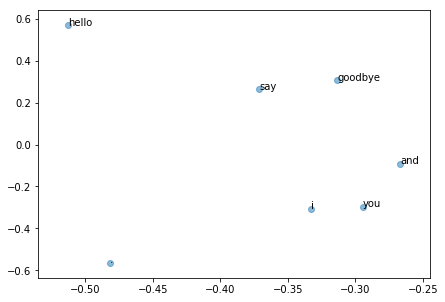

In [14]:
import matplotlib.pyplot as plt

# 將詞向量降為二維方便視覺化
U_visualization = U[:, 0:2]

# visualization
for word, word_id in word2idx.items():
    plt.annotate(word, (U_reduce[word_id, 0], U_reduce[word_id, 1]))
    
plt.scatter(U_reduce[:, 0], U_reduce[:, 1], alpha=0.5)
#plt.axis("off")
plt.tight_layout(pad=0)
#顯示用
plt.show()